## Dependencias

In [ ]:
%pip install -r requirements.txt

In [1]:
import os
import sys
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly_resampler import FigureResampler
from tqdm.auto import tqdm

In [2]:
%cd src
from data import load_signals, load_annotations, annotation_to_30s_labels
%cd ..

c:\Users\ahmat\Documents\_ITBA\5to\1er Cuatrimestre\Neuro\sleep-linear\src
c:\Users\ahmat\Documents\_ITBA\5to\1er Cuatrimestre\Neuro\sleep-linear


In [3]:
data_folder = "./data/"
os.listdir(data_folder)

['RECORDS',
 'RECORDS-v1',
 'sc-aux',
 'SC-subjects.xls',
 'SHA256SUMS.txt',
 'sleep-cassette',
 'sleep-telemetry',
 'ST-subjects.xls']

In [4]:
os.listdir(data_folder + "/sleep-cassette")[:10]

['SC4001E0-PSG.edf',
 'SC4001EC-Hypnogram.edf',
 'SC4002E0-PSG.edf',
 'SC4002EC-Hypnogram.edf',
 'SC4011E0-PSG.edf',
 'SC4011EH-Hypnogram.edf',
 'SC4012E0-PSG.edf',
 'SC4012EC-Hypnogram.edf',
 'SC4021E0-PSG.edf',
 'SC4021EH-Hypnogram.edf']

## Armamos el Dataframe con los archivos a analizar

In [5]:
dfs = []
sub_folder = "/sleep-cassette"
sorted_files = sorted(os.listdir(data_folder + sub_folder))
psg_hypnogram_files = [(p, h) for p, h in zip(sorted_files[::2], sorted_files[1:][::2])]
df_files = pd.DataFrame(psg_hypnogram_files, columns=["psg_file", "label_file"])
df_files["subfolder"] = sub_folder

# Because for the SC study patients were monitored for 2 consecutive nights
df_files["patient_id"] = df_files.psg_file.apply(lambda f: f[:5])
df_files

,psg_file,label_file,subfolder,patient_id
0,SC4001E0-PSG.edf,SC4001EC-Hypnogram.edf,/sleep-cassette,SC400
1,SC4002E0-PSG.edf,SC4002EC-Hypnogram.edf,/sleep-cassette,SC400
2,SC4011E0-PSG.edf,SC4011EH-Hypnogram.edf,/sleep-cassette,SC401
3,SC4012E0-PSG.edf,SC4012EC-Hypnogram.edf,/sleep-cassette,SC401
4,SC4021E0-PSG.edf,SC4021EH-Hypnogram.edf,/sleep-cassette,SC402
...,...,...,...,...
95,SC4492G0-PSG.edf,SC4492GJ-Hypnogram.edf,/sleep-cassette,SC449
96,SC4501E0-PSG.edf,SC4501EW-Hypnogram.edf,/sleep-cassette,SC450
97,SC4502E0-PSG.edf,SC4502EM-Hypnogram.edf,/sleep-cassette,SC450
98,SC4511E0-PSG.edf,SC4511EJ-Hypnogram.edf,/sleep-cassette,SC451


In [6]:
# Lista de IDs de pacientes para el paper
paper_patients = ["SC400", "SC401","SC402","SC403","SC404","SC405", "SC406", "SC407","SC408","SC409"]

# Filtramos el DataFrame df_files para incluir solo las filas donde el patient_id está en paper_patients
df_files_paper = df_files[df_files.patient_id.isin(paper_patients)]
print("Número de archivos PSG únicos en df_files_paper:", df_files_paper.psg_file.nunique())
print("Número de IDs de pacientes únicos en df_files_paper:", df_files_paper.patient_id.nunique())

Número de archivos PSG únicos en df_files_paper: 20
Número de IDs de pacientes únicos en df_files_paper: 10


In [7]:
# Filtramos el DataFrame df_files para incluir solo las filas donde el patient_id NO está en paper_patients
df_files_other = df_files[~df_files.patient_id.isin(paper_patients)]
print("Número de archivos PSG únicos en df_files_other:", df_files_other.psg_file.nunique())
print("Número de IDs de pacientes únicos en df_files_other:", df_files_other.patient_id.nunique())

Número de archivos PSG únicos en df_files_other: 80
Número de IDs de pacientes únicos en df_files_other: 41


### Procesamos las señales de los archivos pacientes del paper

In [10]:
signal_dict = {}

for idx in range(len(df_files)):
    try:
        sig, freq = load_signals(
            data_folder + df_files.iloc[idx].subfolder + "/" + df_files.iloc[idx].psg_file,
            only_info=True,
        )
        for s, f in zip(sig, freq):
            if (s, f) in signal_dict.keys():
                signal_dict[(s, f)].append(idx)
            else:
                signal_dict[(s, f)] = [idx]
    except Exception as e:
        print(f"Error al procesar el archivo {df_files.iloc[idx].psg_file}: {e}")

# Muestra (sig, freq) #grabaciones
[(k, len(v)) for k, v in signal_dict.items()]

[(('EEG Fpz-Cz', 100.0), 100),
 (('EEG Pz-Oz', 100.0), 100),
 (('EOG horizontal', 100.0), 100),
 (('Resp oro-nasal', 1.0), 100),
 (('EMG submental', 1.0), 100),
 (('Temp rectal', 1.0), 100),
 (('Event marker', 1.0), 100)]

In [11]:
common_signals = [
    "EEG Fpz-Cz",
    "EEG Pz-Oz",
    "EOG horizontal",  # All have the same sampling rate (100 Hz)
    "EMG submental",  # Different sampling rate: 100 Hz for telemetry & 1 Hz for cassette
]

## EDA para 1 paciente

In [15]:
data = load_signals(
    data_folder + df_files.iloc[0].subfolder + "/" + df_files.iloc[0].psg_file,
    retrieve_signals=common_signals,
)
print(data_folder + df_files.iloc[0].subfolder + "/" + df_files.iloc[0].psg_file)

./data//sleep-cassette/SC4001E0-PSG.edf


In [16]:
annotations = load_annotations(
    data_folder + df_files.iloc[0].subfolder + "/" + df_files.iloc[0].label_file,
    data_folder + df_files.iloc[0].subfolder + "/" + df_files.iloc[0].psg_file,
)

In [17]:
cats = [
    "Sleep stage ?",
    "Movement time",
    "Sleep stage W",
    "Sleep stage 1",
    "Sleep stage 2",
    "Sleep stage 3",
    "Sleep stage 4",
    "Sleep stage R",
][::-1]

In [18]:
idxs = [s.name for s in data]

fig = FigureResampler(
    make_subplots(
        rows=len(idxs) + 1,
        cols=1,
        shared_xaxes=True,
        subplot_titles=idxs + ["Hypnogram"],
        vertical_spacing=0.05,
    ),
    default_n_shown_samples=2_000,
)

for idx, s in enumerate(data, 1):
    fig.add_trace(
        go.Scattergl(
            x=[],
            y=[],
            name=s.name,
            line_width=1,
        ),
        hf_x=s.index,
        hf_y=s.values,
        row=idx,
        col=1,
    )

fig.add_trace(
    go.Scattergl(
        x=[],
        y=[],
        name="Hypnogram",
        line_width=1.5,
        line_shape="hv",
    ),
    hf_x=annotation_to_30s_labels(annotations).index,
    hf_y=annotation_to_30s_labels(annotations)["label"].astype("category"),
    row=len(idxs) + 1,
    col=1,
)

fig.update_layout(height=900)
fig.update_yaxes(categoryorder="array", categoryarray=cats)

fig.update_layout(
    legend_traceorder="normal",
    template="plotly_dark",
    #     legend=dict(orientation="h", y=1.07, xanchor="right", x=1),
)

fig.show_dash(port=8041)

In [ ]:
# Para ver el grafico generado sin tener que volver a correr todo el codigo descomentar estas lineas
# from IPython.display import Image, display
# image_path = './images/registro_polisonografico_1.png'
# display(Image(filename=image_path))

In [19]:
from scipy.signal import butter, lfilter
from tsflex.processing import SeriesPipeline, SeriesProcessor

def butter_bandpass_filter(sig, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    y = lfilter(b, a, sig)
    return y


# def clipper(sig, min_q=0, max_q=1):
#     return sig.clip(sig.quantile(min_q), sig.quantile(max_q))


eeg_bandpass = SeriesProcessor(
    function=butter_bandpass_filter,
    series_names=["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal"],
    lowcut=0.4,
    highcut=30,
    fs=100,
)

process_pipe = SeriesPipeline(
    [
        eeg_bandpass,
    ]
)

process_pipe

[
	butter_bandpass_filter {'lowcut': 0.4, 'highcut': 30, 'fs': 100} :  ('EEG Fpz-Cz',) ('EEG Pz-Oz',) ('EOG horizontal',)
]

In [20]:
%%time
data_processed = process_pipe.process(data, return_all_series=True)

CPU times: total: 328 ms
Wall time: 620 ms


In [21]:
for s in data_processed:
    idx = idxs.index(s.name.split("_")[-1]) + 1
    fig.add_trace(
        go.Scatter(x=[], y=[], name=s.name + " processed", line_width=1),
        hf_x=s.index,
        hf_y=s.values,
        row=idx,
        col=1,
    )

fig.show_dash(port=8041)

In [ ]:
# Para ver el grafico generado sin tener que volver a correr todo el codigo descomentar estas lineas
# from IPython.display import Image, display
# image_path = './images/registro_polisonografico_2.png'
# display(Image(filename=image_path))

### Extraemos las features

In [22]:
# Create the collection of tsfresh features to extract

tsfresh_settings = {
    "fft_aggregated": [
        {"aggtype": "centroid"},
        {"aggtype": "variance"},
        {"aggtype": "skew"},
        {"aggtype": "kurtosis"},
    ],
    "fourier_entropy": [
        {"bins": 2},
        {"bins": 3},
        {"bins": 5},
        {"bins": 10},
        {"bins": 30},
        {"bins": 60},
        {"bins": 100},
    ],
    "binned_entropy": [
        {"max_bins": 5},
        {"max_bins": 10},
        {"max_bins": 30},
        {"max_bins": 60},
    ],
}

tsfresh_settings

{'fft_aggregated': [{'aggtype': 'centroid'},
  {'aggtype': 'variance'},
  {'aggtype': 'skew'},
  {'aggtype': 'kurtosis'}],
 'fourier_entropy': [{'bins': 2},
  {'bins': 3},
  {'bins': 5},
  {'bins': 10},
  {'bins': 30},
  {'bins': 60},
  {'bins': 100}],
 'binned_entropy': [{'max_bins': 5},
  {'max_bins': 10},
  {'max_bins': 30},
  {'max_bins': 60}]}

In [23]:
import antropy as ant
import scipy.stats as ss
from yasa import bandpower
import scipy.stats as ss
from tsflex.features import (
    FeatureCollection,
    FuncWrapper,
    MultipleFeatureDescriptors,
    FuncWrapper,
)
from tsflex.features.integrations import tsfresh_settings_wrapper


def wrapped_higuchi_fd(x):
    x = np.array(x, dtype="float64")
    return ant.higuchi_fd(x)


bands = [
    (0.4, 1, "sdelta"),
    (1, 4, "fdelta"),
    (4, 8, "theta"),
    (8, 12, "alpha"),
    (12, 16, "sigma"),
    (16, 30, "beta"),
]
bandpowers_ouputs = [b[2] for b in bands] + ["TotalAbsPow"]


def wrapped_bandpowers(x, sf, bands):
    return bandpower(x, sf=sf, bands=bands).values[0][:-2]


time_funcs = [
    np.std,
    ss.iqr,
    ss.skew,
    ss.kurtosis,
    ant.num_zerocross,
    FuncWrapper(
        ant.hjorth_params, output_names=["horth_mobility", "hjorth_complexity"]
    ),
    wrapped_higuchi_fd,
    ant.petrosian_fd,
    ant.perm_entropy,
] + tsfresh_settings_wrapper(tsfresh_settings)

freq_funcs = [
    FuncWrapper(wrapped_bandpowers, sf=100, bands=bands, output_names=bandpowers_ouputs)
]

time_feats = MultipleFeatureDescriptors(
    time_funcs,
    ["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal", "EMG submental"],
    windows=["30s", "60s", "90s"],
    strides="30s",
)
freq_feats = MultipleFeatureDescriptors(
    freq_funcs,
    ["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal"],
    windows=["30s", "60s", "90s"],
    strides="30s",
)

feature_collection = FeatureCollection([time_feats, freq_feats])

In [ ]:
import logging

from tsflex.features.logger import logger
logger.setLevel(level=logging.ERROR)

from tsflex.processing.logger import logger
logger.setLevel(level=logging.ERROR)

feats = feature_collection.calculate(data_processed, return_df=True, show_progress=True)
feats.head()

# Lista Resumida con Explicaciones



## Frecuencia Banda de Potencia (Frequency Band Power)

**Descripción**: Estas características miden la potencia dentro de bandas de frecuencia específicas (alpha, beta, delta, etc.) para diferentes longitudes de ventana.

**Ejemplos**:
- EEG Fpz-Cz__TotalAbsPow__w=X
- EEG Fpz-Cz__alpha__w=X
- EEG Fpz-Cz__beta__w=X
- EEG Fpz-Cz__fdelta__w=X
- EEG Fpz-Cz__sdelta__w=X
- EEG Fpz-Cz__theta__w=X
- EEG Pz-Oz__TotalAbsPow__w=X
- EEG Pz-Oz__alpha__w=X
- EEG Pz-Oz__beta__w=X
- EEG Pz-Oz__fdelta__w=X
- EEG Pz-Oz__sdelta__w=X
- EEG Pz-Oz__theta__w=X

## Medidas de Entropía (Entropy Measures)

**Descripción**: Las características de entropía capturan la complejidad o aleatoriedad en la señal.

**Ejemplos**:
- EEG Fpz-Cz__binned_entropy_{'max_bins': Y}__w=X
- EEG Fpz-Cz__fourier_entropy_{'bins': Y}__w=X
- EEG Fpz-Cz__perm_entropy__w=X
- EEG Pz-Oz__binned_entropy_{'max_bins': Y}__w=X
- EEG Pz-Oz__fourier_entropy_{'bins': Y}__w=X
- EEG Pz-Oz__perm_entropy__w=X
- EMG submental__binned_entropy_{'max_bins': Y}__w=X
- EMG submental__fourier_entropy_{'bins': Y}__w=X
- EMG submental__perm_entropy__w=X

## Características de Transformada de Frecuencia (Frequency Transform Features)

**Descripción**: Estas características se derivan de la transformada de Fourier, capturando varios momentos estadísticos y propiedades.

**Ejemplos**:
- EEG Fpz-Cz__fft_aggregated_{'aggtype': 'Z'}__w=X
- EEG Pz-Oz__fft_aggregated_{'aggtype': 'Z'}__w=X
- EMG submental__fft_aggregated_{'aggtype': 'Z'}__w=X

## Medidas Estadísticas (Statistical Measures)

**Descripción**: Son medidas estadísticas básicas como el rango intercuartil (IQR), curtosis, asimetría y desviación estándar.

**Ejemplos**:
- EEG Fpz-Cz__iqr__w=X
- EEG Fpz-Cz__kurtosis__w=X
- EEG Fpz-Cz__skew__w=X
- EEG Fpz-Cz__std__w=X
- EEG Pz-Oz__iqr__w=X
- EEG Pz-Oz__kurtosis__w=X
- EEG Pz-Oz__skew__w=X
- EEG Pz-Oz__std__w=X
- EMG submental__iqr__w=X
- EMG submental__kurtosis__w=X
- EMG submental__skew__w=X

## Parámetros de Hjorth (Hjorth Parameters)

**Descripción**: Los parámetros de Hjorth miden la complejidad y la movilidad de la señal, proporcionando información sobre las propiedades dinámicas de la serie temporal.

**Ejemplos**:
- EEG Fpz-Cz__hjorth_complexity__w=X
- EEG Fpz-Cz__hjorth_mobility__w=X
- EEG Pz-Oz__hjorth_complexity__w=X
- EEG Pz-Oz__hjorth_mobility__w=X
- EMG submental__hjorth_complexity__w=X
- EMG submental__hjorth_mobility__w=X

## Dimensión Fractal (Fractal Dimension)

**Descripción**: Las dimensiones fractales como Petrosian y Higuchi proporcionan medidas de la complejidad de la señal.

**Ejemplos**:
- EEG Fpz-Cz__petrosian_fd__w=X
- EEG Fpz-Cz__wrapped_higuchi_fd__w=X
- EEG Pz-Oz__petrosian_fd__w=X
- EEG Pz-Oz__wrapped_higuchi_fd__w=X
- EMG submental__petrosian_fd__w=X

## Cruces por Cero (Zero Crossings)

**Descripción**: Estas características cuentan el número de veces que la señal cruza el valor cero dentro de una ventana especificada.

**Ejemplos**:
- EEG Fpz-Cz__num_zerocross__w=X
- EEG Pz-Oz__num_zerocross__w=X
- EMG submental__num_zerocross__w=X

## Variables de Sustitución

- **X**: 1m, 1m30s, 30s (diferentes longitudes de ventana)
- **Y**: 2, 3, 5, 10, 30, 60, 100 (diferentes números de bins)
- **Z**: centroid, kurtosis, skew, variance (diferentes tipos de agregación)

In [ ]:
df = feats.copy()
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=('EEG Fpz-Cz', 'EEG Pz-Oz'))

# Grafico 1
fig.add_trace(go.Scatter(x=df.index, y=df['EEG Fpz-Cz__TotalAbsPow__w=1m'], mode='lines', name='TotalAbsPow__w=1m'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['EEG Fpz-Cz__alpha__w=1m'], mode='lines', name='alpha__w=1m'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['EEG Fpz-Cz__beta__w=1m'], mode='lines', name='beta__w=1m'), row=1, col=1)

# Grafico 2
fig.add_trace(go.Scatter(x=df.index, y=df['EEG Pz-Oz__TotalAbsPow__w=1m'], mode='lines', name='TotalAbsPow__w=1m'), row=2, col=1)

fig.update_layout(title='Gráficos de características EEG a lo largo del tiempo', height=900)
fig.show()

In [ ]:
# Para ver el grafico generado sin tener que volver a correr todo el codigo descomentar estas lineas
# from IPython.display import Image, display
# image_path = './images/EEG_plot.png'
# display(Image(filename=image_path))

# Pipeline para todos los pacientes


In [25]:
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in double_scalars")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in scalar divide")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in divide")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.")

df_feats = []
counter = 0
df_feats_total = pd.DataFrame()

for sub_folder, psg_file, hypnogram_file in tqdm(zip(df_files.subfolder, df_files.psg_file, df_files.label_file)):
    file_folder = data_folder + sub_folder + "/"
    print(str(counter) + ": " + file_folder + psg_file)

    # Load the data, process the data and extract features
    data = load_signals(file_folder + psg_file)
    data_processed = process_pipe.process(data)
    df_feat = feature_collection.calculate(data_processed, return_df=True, window_idx="begin").astype("float32")

    # Add the labels (and reduce features to only data for which we have labels)
    annotations = load_annotations(file_folder + hypnogram_file, file_folder + psg_file)
    annotations = annotation_to_30s_labels(annotations)
    df_feat = df_feat.merge(annotations, left_index=True, right_index=True)

    # Add the file name & folder
    df_feat["psg_file"] = psg_file
    df_feat["patient_id"] = psg_file[:5]

    # Collect the dataframes
    df_feats += [df_feat]

    # Increment counter
    counter += 1

df_feats = pd.concat(df_feats)
df_feats.rename(columns={"description": "label"}, inplace=True)
df_feats.to_parquet("./features/sleep-edf_cassette_features_ALL__90s.parquet")

0it [00:00, ?it/s]

0: ./data//sleep-cassette/SC4001E0-PSG.edf
1: ./data//sleep-cassette/SC4002E0-PSG.edf
2: ./data//sleep-cassette/SC4011E0-PSG.edf
3: ./data//sleep-cassette/SC4012E0-PSG.edf
4: ./data//sleep-cassette/SC4021E0-PSG.edf
5: ./data//sleep-cassette/SC4022E0-PSG.edf
6: ./data//sleep-cassette/SC4031E0-PSG.edf
7: ./data//sleep-cassette/SC4032E0-PSG.edf
8: ./data//sleep-cassette/SC4041E0-PSG.edf
9: ./data//sleep-cassette/SC4042E0-PSG.edf
10: ./data//sleep-cassette/SC4051E0-PSG.edf
11: ./data//sleep-cassette/SC4052E0-PSG.edf
12: ./data//sleep-cassette/SC4061E0-PSG.edf
13: ./data//sleep-cassette/SC4062E0-PSG.edf
14: ./data//sleep-cassette/SC4071E0-PSG.edf
15: ./data//sleep-cassette/SC4072E0-PSG.edf
16: ./data//sleep-cassette/SC4081E0-PSG.edf
17: ./data//sleep-cassette/SC4082E0-PSG.edf
18: ./data//sleep-cassette/SC4091E0-PSG.edf
19: ./data//sleep-cassette/SC4092E0-PSG.edf
20: ./data//sleep-cassette/SC4101E0-PSG.edf
21: ./data//sleep-cassette/SC4102E0-PSG.edf
22: ./data//sleep-cassette/SC4111E0-PSG.ed

# Cargamos los datos para evitar todo el preprocesamiento
Realizamos un EDA sore los mismos

In [71]:
df_feats = pd.read_parquet("./features/sleep-edf_cassette_features_ALL__90s.parquet")
df_feats.shape

(273558, 366)

In [48]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 273558 entries, 1989-04-24 16:13:00 to 1989-06-02 14:34:00
Columns: 366 entries, EEG Fpz-Cz__TotalAbsPow__w=1m to patient_id
dtypes: float32(363), object(3)
memory usage: 387.2+ MB


In [49]:
df_feats["label"].value_counts()

label
Sleep stage W    188377
Sleep stage 2     45016
Sleep stage R     17485
Sleep stage 1     11129
Sleep stage 3      6517
Sleep stage 4      3858
Sleep stage ?      1081
Movement time        95
Name: count, dtype: int64

In [72]:
eeg_signals = [d for d in common_signals if "EEG" in d]
bands = ["alpha", "beta", "sdelta", "fdelta", "sigma", "theta"]
for eeg_sig in eeg_signals:
    eeg_bands = [
        c
        for c in df_feats.columns
        if c.startswith(eeg_sig) and c.split("__")[1] in bands
    ]
    windows = sorted(set(b.split("__")[-1] for b in eeg_bands))
    for window in windows:
        # Select the spectral powers
        delta = (
            df_feats["__".join([eeg_sig, "sdelta", window])]
            + df_feats["__".join([eeg_sig, "fdelta", window])]
        )
        fdelta_theta = (
            df_feats["__".join([eeg_sig, "fdelta", window])]
            + df_feats["__".join([eeg_sig, "theta", window])]
        )
        alpha = df_feats["__".join([eeg_sig, "alpha", window])]
        beta = df_feats["__".join([eeg_sig, "beta", window])]
        theta = df_feats["__".join([eeg_sig, "theta", window])]
        sigma = df_feats["__".join([eeg_sig, "sigma", window])]
        # Calculate the ratios
        df_feats["__".join([eeg_sig, "fdelta+theta", window])] = fdelta_theta.astype("float32")
        df_feats["__".join([eeg_sig, "alpha/theta", window])] = (alpha / theta).astype("float32")
        df_feats["__".join([eeg_sig, "delta/beta", window])] = (delta / beta).astype("float32")
        df_feats["__".join([eeg_sig, "delta/sigma", window])] = (delta / sigma).astype("float32")
        df_feats["__".join([eeg_sig, "delta/theta", window])] = (delta / theta).astype("float32")
df_feats.shape

(273558, 396)

In [73]:
import re
skip_cols = ["psg_file", "label", "patient_id"]
feat_cols = [c for c in df_feats.columns if c not in skip_cols]
pattern = re.compile(r'w=1m(?!\d)')

# Add the 30s features from the minute before and the minute after the epoch (= current sample of 30s) to the epoch
feats_30s = [f for f in df_feats.columns if "w=30s" in f]
feats_60s = [f for f in df_feats.columns if pattern.search(f)]
feats_90s = [f for f in df_feats.columns if "w=1m30s" in f]
print(len(feats_30s), len(feats_60s), len(feats_90s))
dfs = []
for psg_file in df_feats.psg_file.unique():
    sub_df = df_feats[df_feats.psg_file == psg_file]

    sub_df = sub_df.merge(
        sub_df[feats_90s].shift(1).add_suffix("_shift=30s"),
        left_index=True,
        right_index=True,
    )
    sub_df = sub_df.drop(columns=feats_90s)

    sub_df = sub_df.merge(
        sub_df[feats_60s].shift(1).add_suffix("_shift=30s"),
        left_index=True,
        right_index=True,
    )

    sub_df = sub_df.merge(
        sub_df[feats_30s].shift(2).add_suffix("_shift=1m"),
        left_index=True,
        right_index=True,
    )
    sub_df = sub_df.merge(
        sub_df[feats_30s].shift(1).add_suffix("_shift=30s"),
        left_index=True,
        right_index=True,
    )
    sub_df = sub_df.merge(
        sub_df[feats_30s].shift(-1).add_suffix("_shift=-30s"),
        left_index=True,
        right_index=True,
    )
    sub_df = sub_df.merge(
        sub_df[feats_30s].shift(-2).add_suffix("_shift=-1m"),
        left_index=True,
        right_index=True,
    )
    dfs += [sub_df]
df_feats = pd.concat(dfs)
df_feats.shape

131 131 131


(273558, 1051)

In [52]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 273558 entries, 1989-04-24 16:13:00 to 1989-06-02 14:34:00
Columns: 920 entries, EEG Fpz-Cz__TotalAbsPow__w=1m to EEG Pz-Oz__delta/theta__w=30s_shift=-1m
dtypes: float32(917), object(3)
memory usage: 965.3+ MB


In [74]:
# Postprocess labels
df_feats.loc[df_feats["label"] == "Sleep stage 4", "label"] = "Sleep stage 3"
df_feats = df_feats[df_feats["label"] != "Movement time"]
df_feats = df_feats[df_feats["label"] != "Sleep stage ?"]  # Label that is given when recording is done / end of the night

df_feats_paper = df_feats[df_feats.psg_file.isin(df_files_paper.psg_file)]
df_feats_paper.shape

(54479, 1051)

In [75]:
def get_repeat_length(val, arr):
    assert arr[0] == val
    return np.where(arr != val)[0][0] + 1


dfs = []
for psg_file in df_feats_paper["psg_file"].unique():
    sub_df = df_feats[df_feats.psg_file == psg_file]  # .sort_index()
    labels = sub_df["label"].values
    nb_wake_before_sleep = get_repeat_length("Sleep stage W", labels)
    nb_wake_after_sleep = get_repeat_length("Sleep stage W", labels[::-1])
    start_idx = max(0, nb_wake_before_sleep - 30 * 2)
    end_idx = min(-1, -nb_wake_after_sleep + 30 * 2)
    dfs.append(sub_df[start_idx:end_idx])
df_feats_trimmed_paper = pd.concat(dfs)
del dfs

In [76]:
def get_repeat_length(val, arr):
    if arr[0] != val:
        return 0
    return np.where(arr != val)[0][0] + 1


dfs = []
for psg_file in df_feats["psg_file"].unique():
    sub_df = df_feats[df_feats.psg_file == psg_file]  # .sort_index()
    labels = sub_df["label"].values
    nb_wake_before_sleep = get_repeat_length("Sleep stage W", labels)
    nb_wake_after_sleep = get_repeat_length("Sleep stage W", labels[::-1])
    start_idx = max(0, nb_wake_before_sleep - 30 * 2)
    end_idx = min(-1, -nb_wake_after_sleep + 30 * 2)
    dfs.append(sub_df[start_idx:end_idx])
df_feats_trimmed_all = pd.concat(dfs)
del dfs

## Exploratory Data Analysis (EDA)

### Labels plots

<Axes: xlabel='label'>

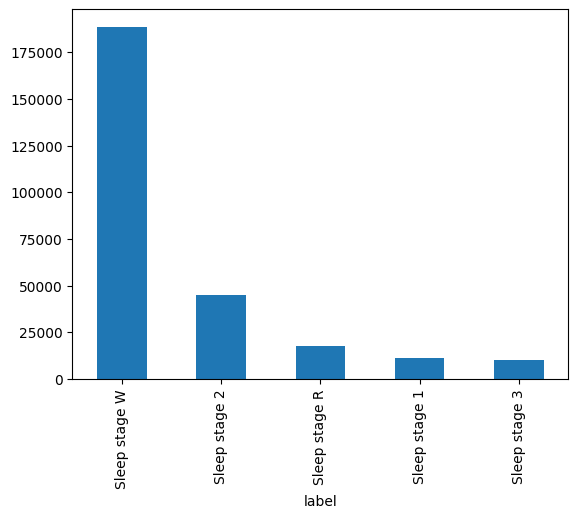

In [63]:
df_feats["label"].value_counts().plot(kind="bar")

<Axes: xlabel='label'>

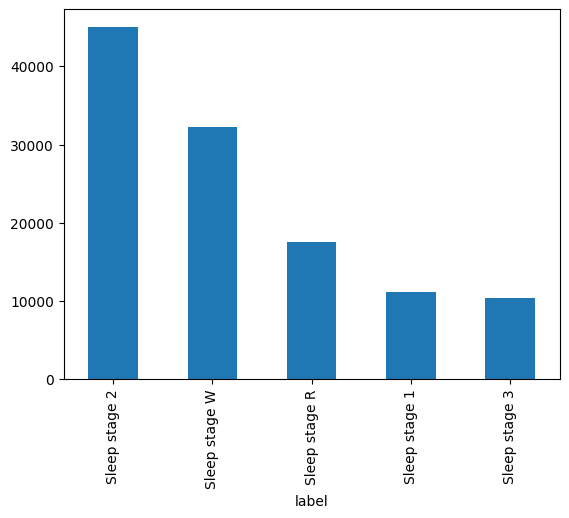

In [64]:
df_feats_trimmed_all["label"].value_counts().plot(kind="bar")

### Space Visualization

In [59]:
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer

feat_cols = [c for c in df_feats_trimmed_all.columns if c not in ["label", "psg_file", "patient_id"]]

#### PCA

(116216, 2)


c:\Users\ahmat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



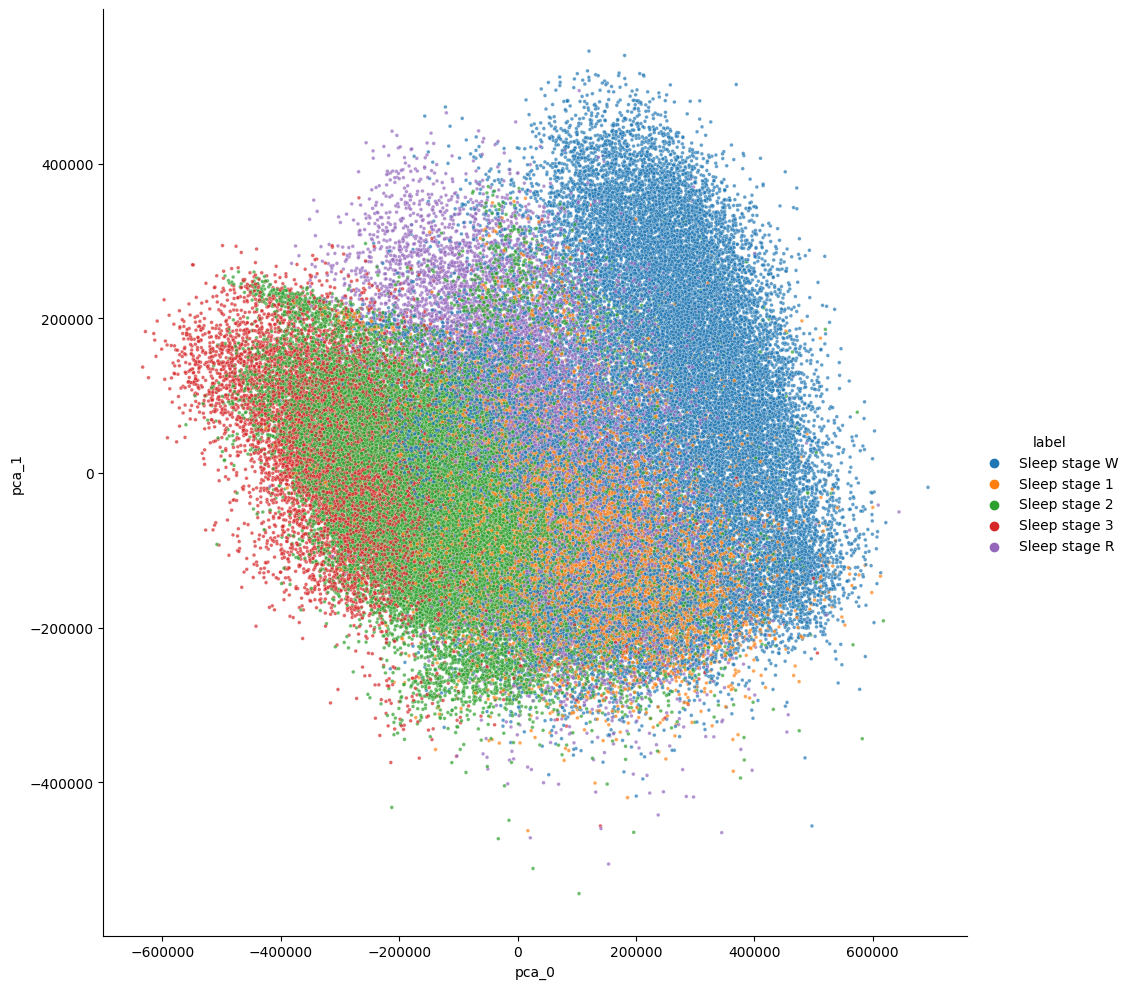

In [61]:
n_components = 2
pca = PCA(n_components)
pca_result = pca.fit_transform(SimpleImputer().fit_transform(df_feats_trimmed_all[feat_cols]))
print(pca_result.shape)

label_col = "label"
pca_result = pd.DataFrame(pca_result).add_prefix("pca_")
pca_result[label_col] = df_feats_trimmed_all[label_col].values

labels = ["Sleep stage W"] + [f"Sleep stage {i}" for i in range(1,4)] + ["Sleep stage R"] 
sns.relplot(
    data=pca_result,
    x="pca_0",
    y="pca_1",
    hue=label_col,
    hue_order=labels,
    height=10,
    kind="scatter",
    s=7,
    alpha=0.7
)

#### t-SNE

(50000, 2)


c:\Users\ahmat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



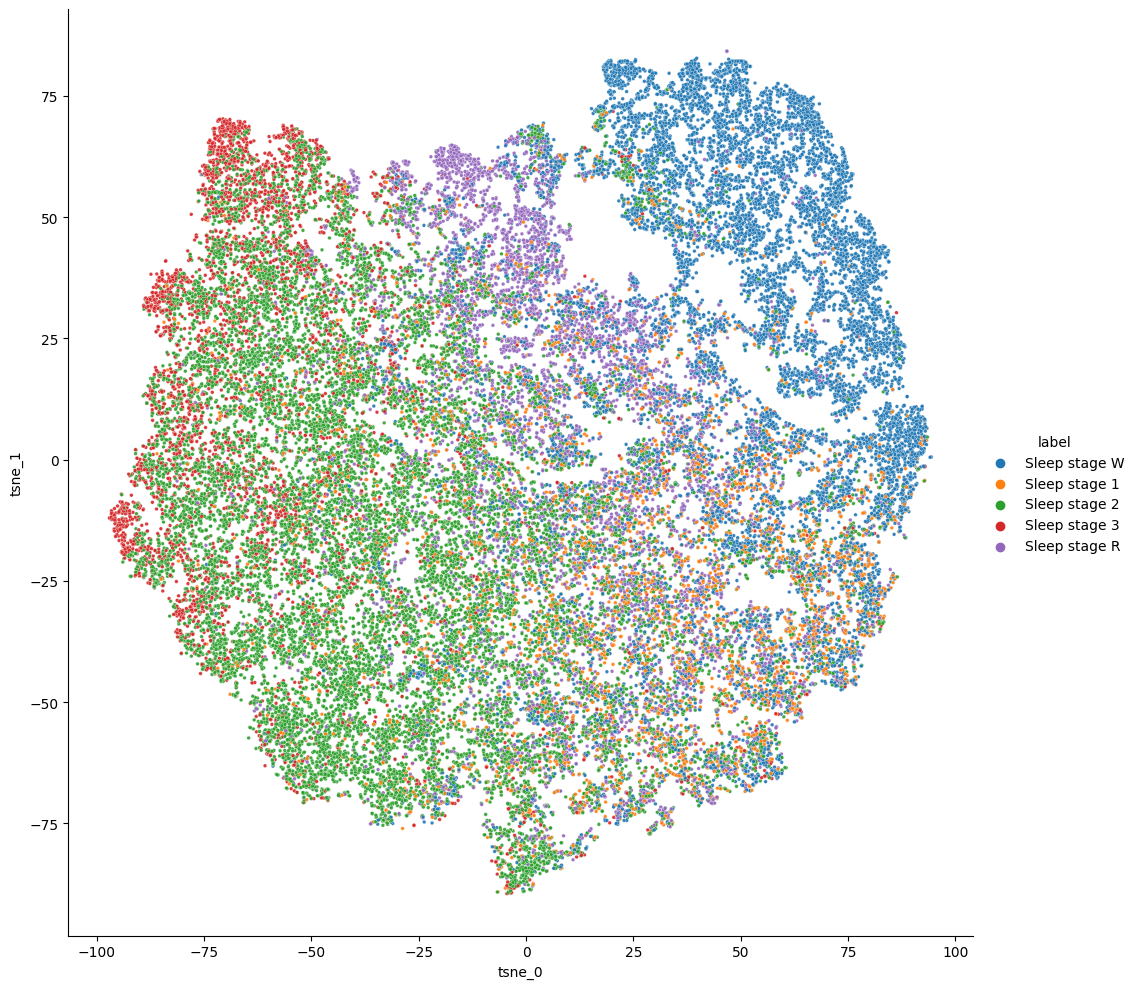

In [65]:
n_components = 2
sample = df_feats_trimmed_all.sample(50_000)  # sample 50k rows

tsne = TSNE(n_components, perplexity=50, n_jobs=30, init='pca', learning_rate='auto')
tsne_result = tsne.fit_transform(SimpleImputer().fit_transform(sample[feat_cols]))
print(tsne_result.shape)

label_col = "label"
tsne_result = pd.DataFrame(tsne_result).add_prefix("tsne_")
tsne_result[label_col] = sample[label_col].values

labels = ["Sleep stage W"] + [f"Sleep stage {i}" for i in range(1,4)] + ["Sleep stage R"] 
sns.relplot(
    data=tsne_result,
    x="tsne_0",
    y="tsne_1",
    hue=label_col,
    hue_order=labels,
    height=10,
    kind="scatter",
    s=7,
    alpha=0.9
)

# ML model

In [77]:
# Subset of data that does not contain the SC-EDF-20 patients
df_feats_trimmed = df_feats_trimmed_all[~df_feats_trimmed_all.psg_file.isin(df_feats_trimmed_paper.psg_file.unique())]
df_feats_trimmed.shape

(95216, 1051)

In [78]:
# Label stats for the SC-EDF-78 \ SC-EDF20 data
df_feats_trimmed["label"].value_counts()

label
Sleep stage 2    36089
Sleep stage W    28594
Sleep stage R    13792
Sleep stage 1     9440
Sleep stage 3     7301
Name: count, dtype: int64

In [79]:
# Label stats for the SC-EDF-20 data
print(len(df_feats_trimmed_paper))
df_feats_trimmed_paper["label"].value_counts()

21000


label
Sleep stage 2    8927
Sleep stage R    3693
Sleep stage W    3617
Sleep stage 3    3074
Sleep stage 1    1689
Name: count, dtype: int64

In [80]:
# Label stats for the SC-EDF-78 data
print(len(df_feats_trimmed_all))
df_feats_trimmed_all["label"].value_counts()

116216


label
Sleep stage 2    45016
Sleep stage W    32211
Sleep stage R    17485
Sleep stage 1    11129
Sleep stage 3    10375
Name: count, dtype: int64

### Nan features

In [23]:
no_shift_cols = [c for c in df_feats_trimmed_all.columns if not "shift=" in c]# or "w=1m" in c or "w=1m30s" in c]
len(no_shift_cols)

265

In [24]:
normal_nan_mask = (df_feats_trimmed_all[no_shift_cols].isna().sum() / df_feats_trimmed_all.psg_file.nunique()).isin([0, 1, 2])
df_feats_trimmed_all[np.array(no_shift_cols)[~normal_nan_mask]].isna().sum().sort_values()[::-1]

EMG submental__wrapped_higuchi_fd__w=30s                        44
EMG submental__skew__w=30s                                      44
EMG submental__kurtosis__w=30s                                  44
EMG submental__hjorth_complexity__w=30s                         44
EMG submental__fft_aggregated_{'aggtype': 'skew'}__w=30s        44
EMG submental__fft_aggregated_{'aggtype': 'kurtosis'}__w=30s    44
EMG submental__horth_mobility__w=30s                             9
EMG submental__fourier_entropy_{'bins': 60}__w=30s               9
EMG submental__fourier_entropy_{'bins': 5}__w=30s                9
EMG submental__fourier_entropy_{'bins': 3}__w=30s                9
EMG submental__fourier_entropy_{'bins': 30}__w=30s               9
EMG submental__fourier_entropy_{'bins': 2}__w=30s                9
EMG submental__fourier_entropy_{'bins': 10}__w=30s               9
EMG submental__fourier_entropy_{'bins': 100}__w=30s              9
dtype: int64

In [25]:
df_feats_trimmed_all["psg_file"][df_feats_trimmed_all[np.array(no_shift_cols)[~normal_nan_mask]].isna().any(axis=1)].value_counts()

psg_file
SC4332F0-PSG.edf    44
Name: count, dtype: int64

In [26]:
df_feats_trimmed_all[np.array(no_shift_cols)[~normal_nan_mask]].isna().any(axis=1).sum() / len(df_feats_trimmed_all)

0.00037860535554484754

## Simple Linear Pipeline for the ML model

In [40]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    f1_score,
    cohen_kappa_score,
    log_loss,
)
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import SGDClassifier

In [41]:
%cd src
from visualizations import plot_linear_classification_coefs
from visualizations import plot_learning_curve
from visualizations import plot_confusion_matrix
%cd ..

c:\Users\ahmat\Documents\_ITBA\5to\1er Cuatrimestre\Neuro\sleep-linear\src
c:\Users\ahmat\Documents\_ITBA\5to\1er Cuatrimestre\Neuro\sleep-linear


In [86]:
### Create pipeline
pipe = Pipeline(
    [
        ("impute", SimpleImputer()),
        ("scale", QuantileTransformer(n_quantiles=100, subsample=200_000, random_state=0)),
        (
            "linear_model",
            SGDClassifier(
                loss="log_loss",
                average=True,
                class_weight="balanced",
                n_jobs=5,
                random_state=0,
            ),
        ),
    ]
)

In [84]:
print(df_feats_trimmed.columns.tolist())
print(feat_cols)
missing_cols = [col for col in feat_cols if col not in df_feats_trimmed.columns]
len(missing_cols)
if missing_cols:
    feat_cols = [col for col in feat_cols if col in df_feats_trimmed.columns]
    print("Updated feature columns:", feat_cols)

Updated feature columns: ['EEG Fpz-Cz__TotalAbsPow__w=1m', 'EEG Fpz-Cz__TotalAbsPow__w=30s', 'EEG Fpz-Cz__alpha__w=1m', 'EEG Fpz-Cz__alpha__w=30s', 'EEG Fpz-Cz__beta__w=1m', 'EEG Fpz-Cz__beta__w=30s', "EEG Fpz-Cz__binned_entropy_{'max_bins': 10}__w=1m", "EEG Fpz-Cz__binned_entropy_{'max_bins': 10}__w=30s", "EEG Fpz-Cz__binned_entropy_{'max_bins': 30}__w=1m", "EEG Fpz-Cz__binned_entropy_{'max_bins': 30}__w=30s", "EEG Fpz-Cz__binned_entropy_{'max_bins': 5}__w=1m", "EEG Fpz-Cz__binned_entropy_{'max_bins': 5}__w=30s", "EEG Fpz-Cz__binned_entropy_{'max_bins': 60}__w=1m", "EEG Fpz-Cz__binned_entropy_{'max_bins': 60}__w=30s", 'EEG Fpz-Cz__fdelta__w=1m', 'EEG Fpz-Cz__fdelta__w=30s', "EEG Fpz-Cz__fft_aggregated_{'aggtype': 'centroid'}__w=1m", "EEG Fpz-Cz__fft_aggregated_{'aggtype': 'centroid'}__w=30s", "EEG Fpz-Cz__fft_aggregated_{'aggtype': 'kurtosis'}__w=1m", "EEG Fpz-Cz__fft_aggregated_{'aggtype': 'kurtosis'}__w=30s", "EEG Fpz-Cz__fft_aggregated_{'aggtype': 'skew'}__w=1m", "EEG Fpz-Cz__fft_a

In [87]:
### Fit the pipeline
pipe.fit(df_feats_trimmed[feat_cols], df_feats_trimmed["label"])

Pipeline(steps=[('impute', SimpleImputer()),
                ('scale',
                 QuantileTransformer(n_quantiles=100, random_state=0,
                                     subsample=200000)),
                ('linear_model',
                 SGDClassifier(average=True, class_weight='balanced',
                               loss='log_loss', n_jobs=5, random_state=0))])

In [88]:
print("Training data:")
preds = pipe.predict(df_feats_trimmed[feat_cols])
preds_proba = pipe.predict_proba(df_feats_trimmed[feat_cols])
print("Log loss:", log_loss(y_true=df_feats_trimmed["label"], y_pred=preds_proba))
print(classification_report(y_true=df_feats_trimmed["label"], y_pred=preds))

Training data:
Log loss: 0.4854333029189249
               precision    recall  f1-score   support

Sleep stage 1       0.48      0.47      0.48      9440
Sleep stage 2       0.87      0.83      0.85     36089
Sleep stage 3       0.73      0.89      0.80      7301
Sleep stage R       0.81      0.85      0.83     13792
Sleep stage W       0.93      0.91      0.92     28594

     accuracy                           0.83     95216
    macro avg       0.77      0.79      0.78     95216
 weighted avg       0.83      0.83      0.83     95216



In [89]:
print("Testing data:")
preds = pipe.predict(df_feats_trimmed_paper[feat_cols])
preds_proba = pipe.predict_proba(df_feats_trimmed_paper[feat_cols])
print("Log loss:", log_loss(y_true=df_feats_trimmed_paper["label"], y_pred=preds_proba))
print(classification_report(y_true=df_feats_trimmed_paper["label"], y_pred=preds))

Testing data:
Log loss: 0.4385168937448232
               precision    recall  f1-score   support

Sleep stage 1       0.56      0.37      0.44      1689
Sleep stage 2       0.92      0.85      0.88      8927
Sleep stage 3       0.83      0.94      0.88      3074
Sleep stage R       0.78      0.91      0.84      3693
Sleep stage W       0.89      0.94      0.92      3617

     accuracy                           0.85     21000
    macro avg       0.80      0.80      0.79     21000
 weighted avg       0.85      0.85      0.84     21000



In [90]:
print("F1 macro: ", f1_score(preds, df_feats_trimmed_paper["label"], average="macro"))
print("Bal. Acc: ", balanced_accuracy_score(preds, df_feats_trimmed_paper["label"]))
print("Kappa:    ", cohen_kappa_score(preds, df_feats_trimmed_paper["label"]))
print("Log loss :", log_loss(y_true=df_feats_trimmed_paper["label"], y_pred=preds_proba))
# Very bad metric, but appearantly many report it
print("Acc:      ", accuracy_score(preds, df_feats_trimmed_paper["label"]))

F1 macro:  0.7924339866371551
Bal. Acc:  0.7951192127963796
Kappa:     0.7970313829773988
Log loss : 0.4385168937448232
Acc:       0.8504761904761905


In [91]:
print("F1 macro: ", f1_score(preds, df_feats_trimmed_paper["label"], average="macro"))
print("Bal. Acc: ", balanced_accuracy_score(preds, df_feats_trimmed_paper["label"]))
print("Kappa:    ", cohen_kappa_score(preds, df_feats_trimmed_paper["label"]))
print("Log loss :", log_loss(y_true=df_feats_trimmed_paper["label"], y_pred=preds_proba))
# Very bad metric, but appearantly many report it
print("Acc:      ", accuracy_score(preds, df_feats_trimmed_paper["label"]))

F1 macro:  0.7924339866371551
Bal. Acc:  0.7951192127963796
Kappa:     0.7970313829773988
Log loss : 0.4385168937448232
Acc:       0.8504761904761905


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

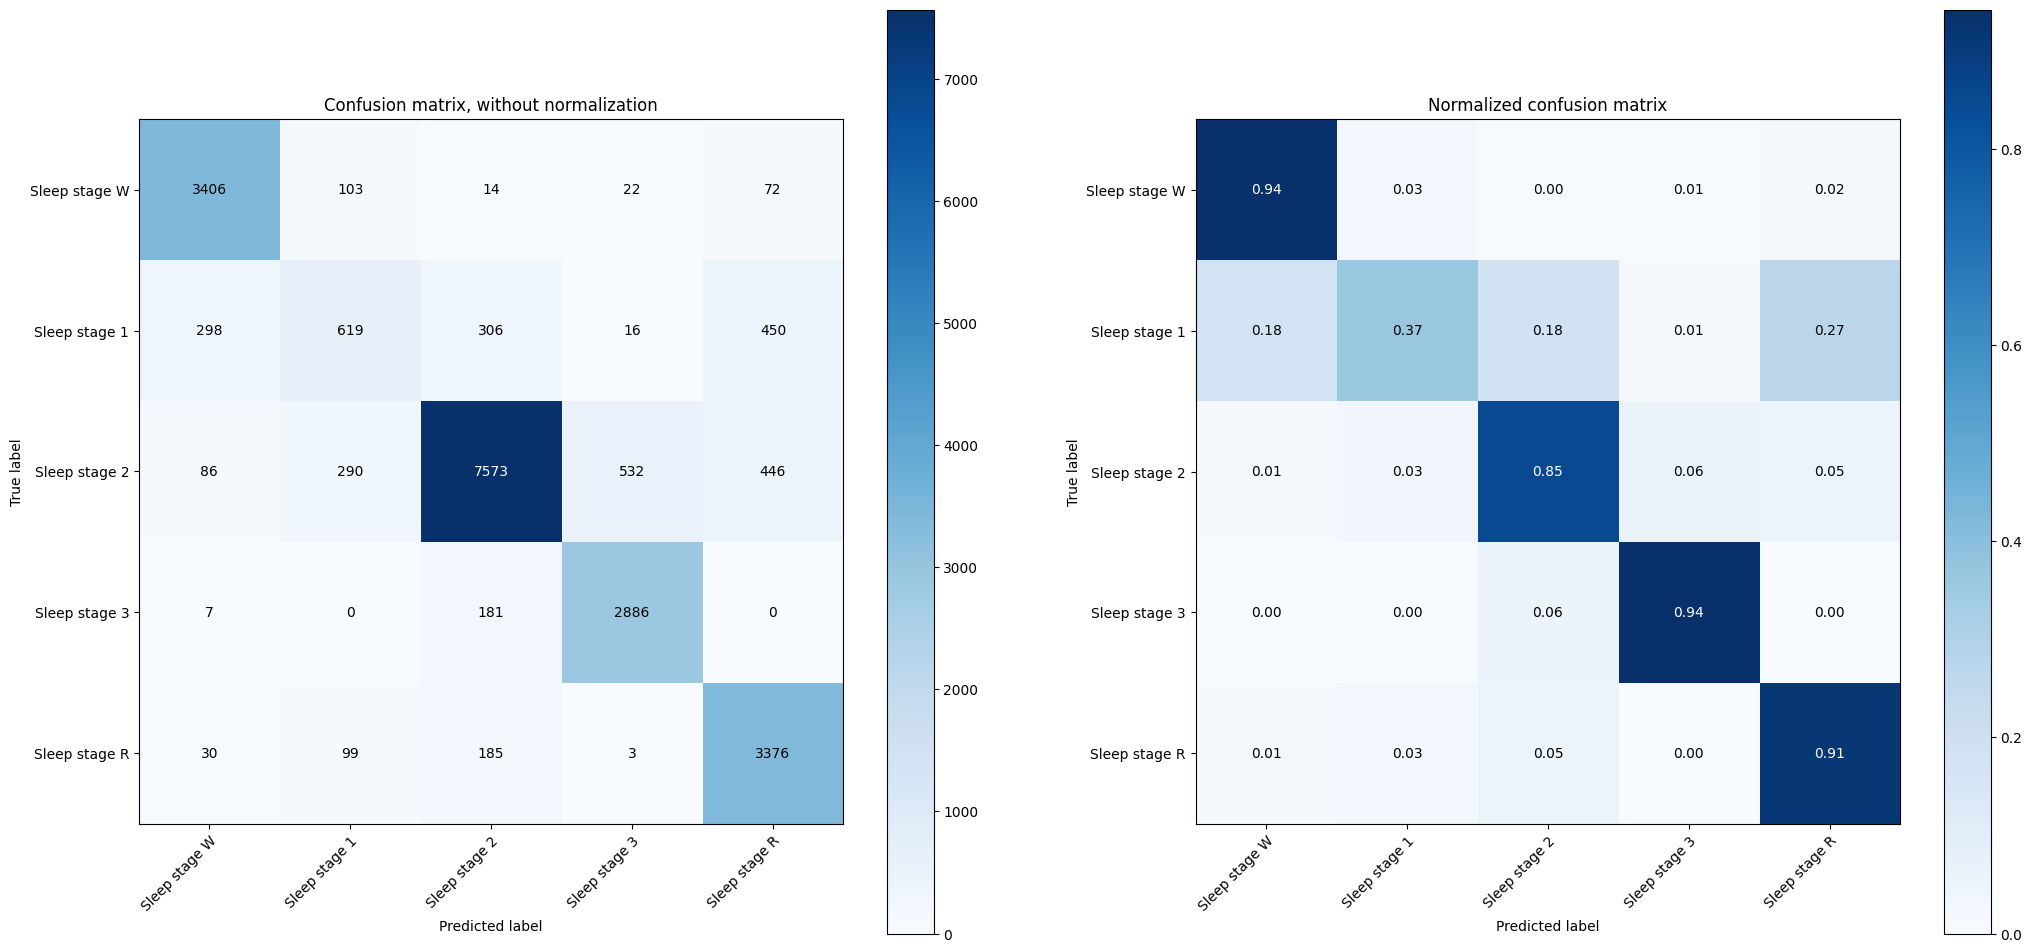

In [92]:
classes = [
    'Sleep stage W',
    'Sleep stage 1',
    'Sleep stage 2',
    'Sleep stage 3',
    'Sleep stage R'
]

plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=df_feats_trimmed_paper["label"], classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=df_feats_trimmed_paper["label"], classes=classes, normalize=True, ax=ax)

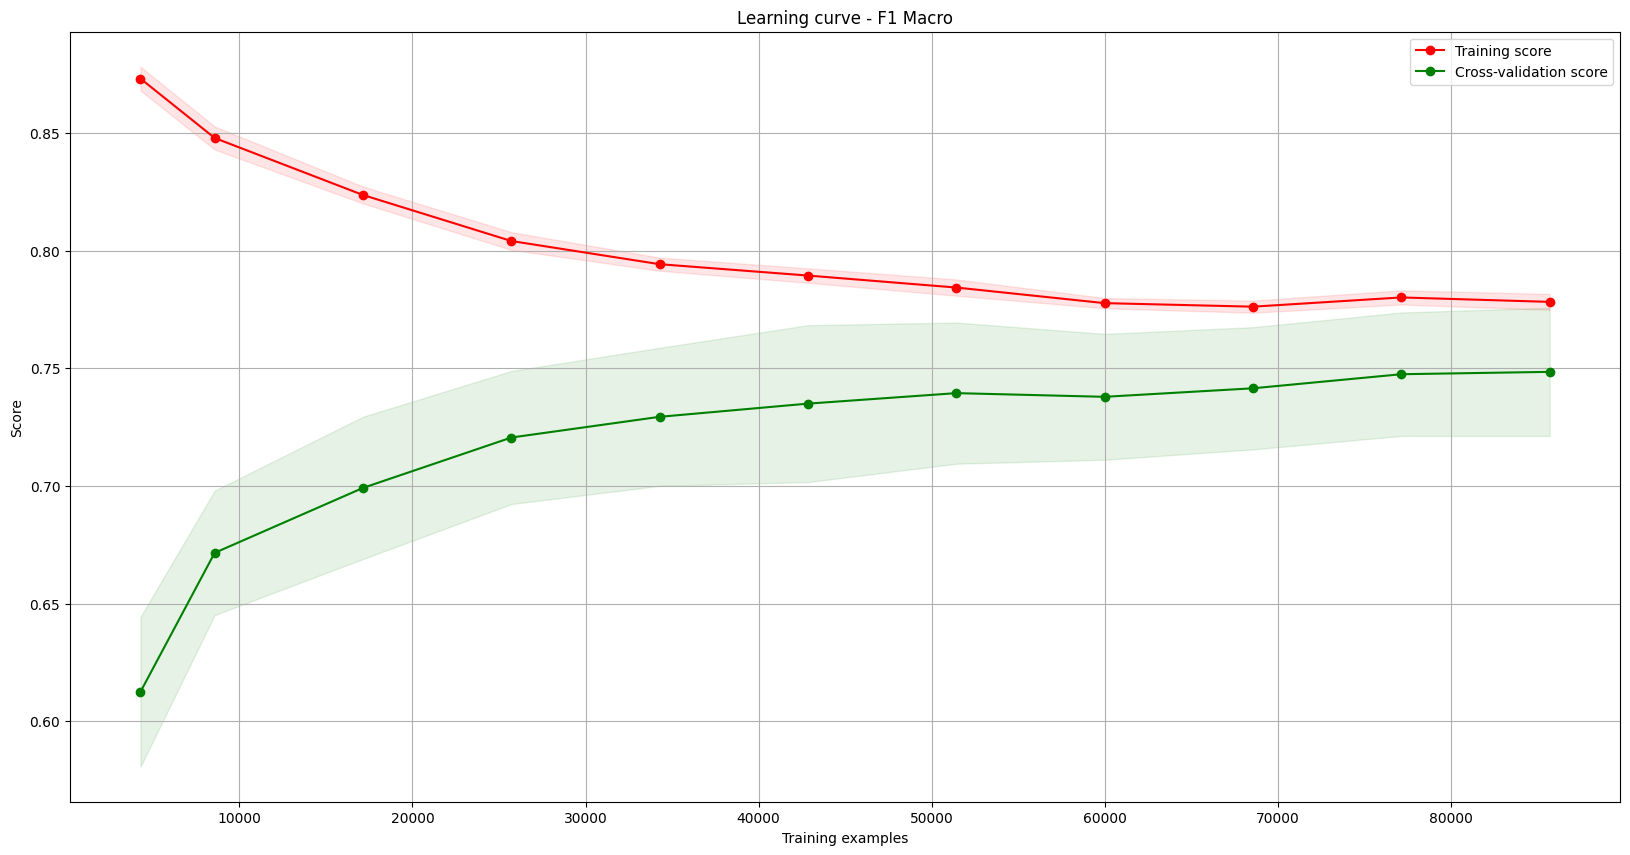

In [93]:
cv = StratifiedGroupKFold(n_splits=10).split(
    df_feats_trimmed[feat_cols],
    df_feats_trimmed["label"],
    groups=df_feats_trimmed.patient_id,
)
_ = plot_learning_curve(
    pipe,
    title="Learning curve - F1 Macro",
    X=df_feats_trimmed[feat_cols],
    y=df_feats_trimmed["label"],
    cv=cv,
    scoring="f1_macro",
    n_jobs=25,
    train_sizes=[0.05] + list(np.linspace(0.1,1,10))
)